# Обучение с учителем: качество модели

<b>ПРОЕКТ: Обучение с учителем: качество модели</b>

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. 

<b>ЦЕЛЬ ПРОЕКТА</b>

Цель проекта заключается в:

<ul>
<li>построении модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;
<li>выделении сегментов покупателей и разработке для них персонализированных предложений на основании данных модели и данных о прибыльности клиентов, дополнительно полученных от финансового департамента (какой доход каждый покупатель приносил компании за последние три месяца).
</ul>

<b>ПЛАН ИССЛЕДОВАНИЯ</b> (согласно заданию)

<ol>
<li>Загрузка данных<br>
Чтение данных из файлов. Проверка соответствия описанию.
<li>Предобработка данных<br>
Проведение необходимой предобработки.    
<li>Исследовательский анализ данных<br>
Отбор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
<li>Объединение таблиц<br>
Объединение таблиц <b>market_file.csv</b>, <b>market_money.csv</b>, <b>market_time.csv</b>.
<li>Корреляционный анализ признаков<br>
Корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Устранение мультиколлинеарности.
<li>Использование пайплайнов<br>
Использование пайплайнов для выбора лучшей из моделей <b>KNeighborsClassifier()</b>, <b>DecisionTreeClassifier()</b>, <b>LogisticRegression()</b> и  <b>SVC()</b> по заданной метрике.    
<li>Анализ важности признаков<br>
Оценка важности признаков лучшей модели.
<li>Сегментация покупателей
Выделение сегментов на основе моделирования и данных о прибыльности клиентов. Формулирование предложений по увеличению активности клиентов выбранного сегмента.
<li>Формулирование итоговых выводов<br>
</ol> 

In [1]:
#### необходимая установка
!pip install phik 
!pip install shap
#!pip install scikit-learn==1.4.2
!pip install -U scikit-learn

# необходимый импорт
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from phik.report import plot_correlation_matrix
from phik import phik_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# кодировщики и нормировщики
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

# класс для работы с пропусками
from sklearn.impute import SimpleImputer

# инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV

# метрики
from sklearn.metrics import roc_auc_score

# модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import shap

## Загрузка данных

In [2]:
# Открытие файлов данных и получение общей информации.
market_file=pd.read_csv('/datasets/market_file.csv') # данные о поведении покупателя на сайте
print('Данные о market_file.csv\n')
market_file.info()
display(market_file)
print('\n')

market_money=pd.read_csv('/datasets/market_money.csv') # данные о выручке, которую получает магазин с покупателя
print('Данные о market_money.csv\n')
market_money.info()
display(market_money)
print('\n')

market_time=pd.read_csv('/datasets/market_time.csv') # данные о времени (в мин), которое покупатель провёл на сайте
print('Данные о market_time.csv\n')
market_time.info()
display(market_time)
print('\n')

money=pd.read_csv('/datasets/money.csv',sep=';',decimal = ',') # данные о среднемесячной прибыли от покупателя за последние 3 месяца
print('Данные о money.csv\n')
money.info()
display(money)
print('\n')

Данные о market_file.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошиб

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7




Данные о market_money.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0




Данные о market_time.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдцщий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10




Данные о money.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
...,...,...
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03


### Вывод по п. 1 Загрузка данных
Файлы данных <i>market_file.csv</i>, <i>market_money.csv</i>, <i>market_time.csv</i> и <i>money.csv</i> открыты,
выведены общие сведения, выведены данные датафреймов.

Данные в таблицах, в целом, соответствуют описанию. Вопрос возникает лишь к единице измерения значений в столбце <i>"Прибыль"</i> таблицы <i>money.csv</i>. Однако в исследовании по всей видимости на будут интересовать лишь относительные значения этих данных.

Разделителем в файле <i>money.csv</i> является ';'.

При изучении общих сведений были обнаружены нарушения оформления имен столбцов:
<ul>
<li>используется кириллица;
<li>вместо snake-case - пробелы;
<li>имена начинаются с прописных букв.    
</ul>
Однако по условию задания имена столбцов наборов данных можно оставить без изменений.

## Предобработка данных

### Изменение типов данных

Следует изменить типы данных следующих столбцов <b>market_file</b>:    
<table align=left>
<tr><th>номер</th><th>столбец</th><th>тип до</th><th>тип после</th></tr>
<tr><td>0</td><td>id</td><td>int64</td><td>int32</td></tr>
<tr><td>4</td><td>Маркет_актив_6_мес</td><td>float64</td><td>float32</td></tr>
<tr><td>5</td><td>Маркет_актив_тек_мес</td><td>int64</td><td>int32</td></tr>
<tr><td>6</td><td>Длительность</td><td>int64</td><td>int32</td></tr>
<tr><td>7</td><td>Акционные_покупки</td><td>float64</td><td>float32</td></tr>    
<tr><td>9</td><td>Средний_просмотр_категорий_за_визит</td><td>int64</td><td>int32</td></tr>
<tr><td>10</td><td>Неоплаченные_продукты_штук_квартал</td><td>int64</td><td>int32</td></tr>
<tr><td>11</td><td>Ошибка_сервиса</td><td>int64</td><td>int32</td></tr>    
<tr><td>12</td><td>Страниц_за_визит</td><td>int64</td><td>int32</td></tr>        
</table>

In [3]:
# изменение типов market_file
market_file['id']=market_file['id'].astype('int32')

market_file['Маркет_актив_6_мес']=market_file['Маркет_актив_6_мес'].astype('float32')

market_file['Маркет_актив_тек_мес']=market_file['Маркет_актив_тек_мес'].astype('int32')

market_file['Длительность']=market_file['Длительность'].astype('int32')

market_file['Акционные_покупки']=market_file['Акционные_покупки'].astype('float32')

market_file['Средний_просмотр_категорий_за_визит']=market_file['Средний_просмотр_категорий_за_визит'].astype('int32')

market_file['Неоплаченные_продукты_штук_квартал']=market_file['Неоплаченные_продукты_штук_квартал'].astype('int32')

market_file['Ошибка_сервиса']=market_file['Ошибка_сервиса'].astype('int32')

market_file['Страниц_за_визит']=market_file['Страниц_за_визит'].astype('int32')

# проверка
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int32  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float32
 5   Маркет_актив_тек_мес                 1300 non-null   int32  
 6   Длительность                         1300 non-null   int32  
 7   Акционные_покупки                    1300 non-null   float32
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int32  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int32  
 11  Ошибка_сервиса                

Новые типы соответствуют характеру данных, а данные при этом занимают меньше памяти.<br>
<b>Размер до: 132.2 КВ, размер после: 86.5 КВ (уменьшение на 35%)</b>

Следует изменить типы данных следующих столбцов <b>market_money</b>:    
<table align=left>
<tr><th>номер</th><th>столбец</th><th>тип до</th><th>тип после</th></tr>
<tr><td>0</td><td>id</td><td>int64</td><td>int32</td></tr>
<tr><td>2</td><td>Выручка</td><td>float64</td><td>float32</td></tr>
</table>

In [4]:
# изменение типов market_money
market_money['id']=market_money['id'].astype('int32')
market_money['Выручка']=market_money['Выручка'].astype('float32')

# проверка
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int32  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float32
dtypes: float32(1), int32(1), object(1)
memory usage: 61.1+ KB


Новые типы соответствуют характеру данных, а данные при этом занимают меньше памяти.<br>
<b>Размер до: 91.5 КВ, размер после: 61.1 КВ (уменьшение на 33%)</b>

In [5]:
# изменение типов market_time
market_time['id']=market_time['id'].astype('int32')
market_time['минут']=market_time['минут'].astype('int32')

# проверка
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int32 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int32 
dtypes: int32(2), object(1)
memory usage: 40.8+ KB


Новые типы соответствуют характеру данных, а данные при этом занимают меньше памяти.<br>
<b>Размер до: 61.1 КВ, размер после: 40.8 КВ (уменьшение на 33%)</b>

In [6]:
# изменение типов money
money['id']=money['id'].astype('int32')
money['Прибыль']=money['Прибыль'].astype('float32')

# проверка
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int32  
 1   Прибыль  1300 non-null   float32
dtypes: float32(1), int32(1)
memory usage: 10.3 KB


Новые типы соответствуют характеру данных, а данные при этом занимают меньше памяти.<br>
<b>Размер до: 20.4 КВ, размер после: 10.3 КВ (уменьшение на 50%)</b>

### Поиск пропусков
Пропущенные значения в датафреймах отсутствуют, о чем можно судить по выводу .info() - числа entries совпадают по всем столбцам.

### Поиск дубликатов
В датафрейме market_file строка - запись о пользователе с уникальным идентификатором id, и совпадения в этом столбце - признак ошибки.

Остальные 3 датафрейма по своей сути могут иметь несколько записей об одном пользователе, поэтому совпадения в столбце id - не ошибка. При этом размер группировки по id пользователя в этих датафреймах должен совпадать с числом записей в market_file, чтобы данные по каждому пользователю были полны.  

In [7]:
# поиск дубликатов в market_file
print('Число строк в market_file с совпадением в \'id\' :',market_file['id'].duplicated().sum(),'\n')

# проверка размера группировок остальных датафреймов по столбцу id
print('Число записей в market_file :',len(market_file),'\n')
print('Размер группровки market_money по \'id\' : ',len(market_money.groupby('id')))
print('Размер группровки market_time по \'id\' : ',len(market_time.groupby('id')))
print('Размер группровки money по \'id\' : ',len(money.groupby('id')))

Число строк в market_file с совпадением в 'id' : 0 

Число записей в market_file : 1300 

Размер группровки market_money по 'id' :  1300
Размер группровки market_time по 'id' :  1300
Размер группровки money по 'id' :  1300


### Правка категориальных значений
В категориальных значениях датафреймов <i>market_file</i>, <i>market_time</i> опечатки. Их следует исправить: 

In [8]:
# категориальные значения market_file
print('Тип сервиса:\n------------')
print(market_file['Тип сервиса'].value_counts())
market_file['Тип сервиса'] = [ii.replace('тт','т') for ii in market_file['Тип сервиса']]

# категориальные значения market_time
print('\nПериод:\n-------')
print(market_time['Период'].value_counts())
market_time['Период'] = [ii.replace('предыдцщий','предыдущий') for ii in market_time['Период']]

Тип сервиса:
------------
стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

Период:
-------
предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64


### Вывод по п. 2 Предобработка данных
В датафреймах <i>market_file</i>, <i>market_money</i>, <i>market_time</i> типы данных столбцов были изменены на типы, характерные для данных в этих столбцах.

Пропусков в данных не обнаружено.

Дубликатов в данных не обнаружено.

В некоторых категориальных признаках датафреймов <i>market_file</i>, <i>market_time</i> обнаружены опечатки. Опечатки устранены.

## Исследовательский анализ данных
### Анализ данных в market_file
Ниже выполнен анализ признаков в <b>market_file</b>, описания и распределения для количественных, круговые диаграммы для качественных. 

In [9]:
# построитель гистограммы и ящика с усами
def hist_boxplot(col,ttl,lbl):
    print(market_file[col].describe())

    market_file[col].hist(bins=50)
    plt.title(ttl+', гистограмма')
    plt.xlabel(lbl)
    plt.ylabel('Частота')
    plt.show()

    pd.DataFrame(data=market_file[col],columns=[col]).boxplot()
    plt.title(ttl+', ящик с усами')
    plt.ylabel(lbl)
    plt.show()

# построитель гистграммы countplot
def counts_countplot(col,ttl,lbl):
    bb=market_file.value_counts(col)
    print(bb)    
    
    sns.countplot(x=col,data=market_file)
    plt.title(ttl+', гистограмма countplot')
    plt.xlabel(lbl)
    plt.ylabel('Частота')
    plt.show()
    
# построитель круговой диаграммы
def counts_pie(col):
    bb=market_file.value_counts(col)
    print(bb)

    plt.pie(bb.values, explode=[0.05 for ee in range(len(bb))], autopct='%4.2f%%',labels=bb.index.tolist())
    plt.axis("equal")
    plt.title(col)
    plt.show()

Покупательская активность
Прежний уровень    802
Снизилась          498
dtype: int64


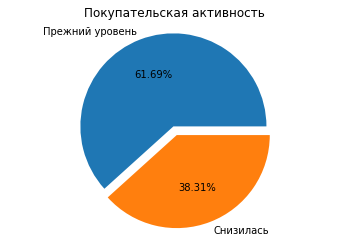

In [10]:
# 1 Покупательская активность
counts_pie('Покупательская активность')

Тип сервиса
стандарт    924
премиум     376
dtype: int64


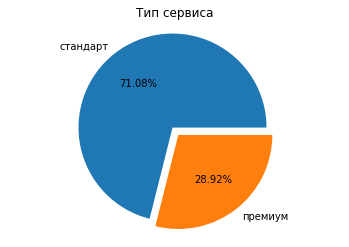

In [11]:
# 2 Тип сервиса
counts_pie('Тип сервиса')

Разрешить сообщать
да     962
нет    338
dtype: int64


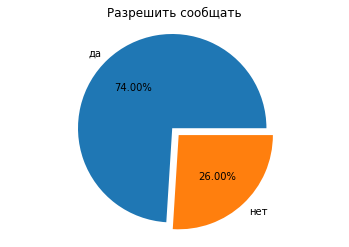

In [12]:
# 3 Разрешить сообщать
counts_pie('Разрешить сообщать')

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64


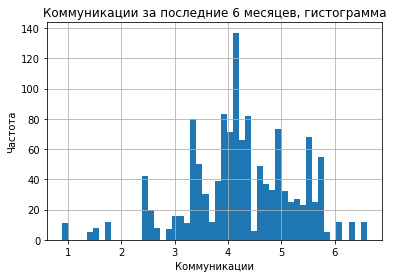

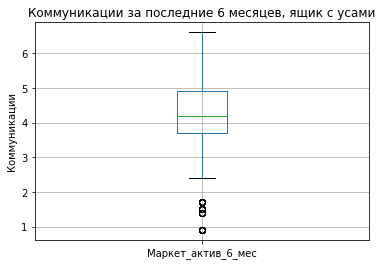

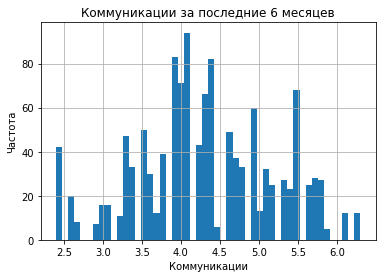

In [13]:
# 4 Маркет_актив_6_мес
hist_boxplot('Маркет_актив_6_мес','Коммуникации за последние 6 месяцев','Коммуникации')

# Видим распределение, напоминающее нормальное, с центром в ~4.2.
# На диаграмме размаха значения <2 обозначены как выбросы, удалим их:
ii=market_file[(market_file['Маркет_актив_6_мес']<2)|(market_file['Маркет_актив_6_мес']>6.5)].index
market_file=market_file.drop(index=ii).reset_index(drop=True)

# Итоговая гистограмма
market_file['Маркет_актив_6_мес'].hist(bins=50)
plt.title('Коммуникации за последние 6 месяцев')
plt.xlabel('Коммуникации')
plt.ylabel('Частота')
plt.show()

In [14]:
print(len(market_file['Маркет_актив_6_мес'].value_counts()))

36


Маркет_актив_тек_мес
4    644
5    312
3    296
dtype: int64


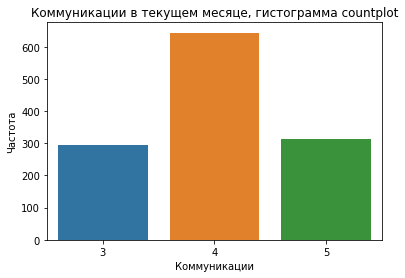

In [15]:
# 5 Маркет_актив_тек_мес - количественный дискретный.
counts_countplot('Маркет_актив_тек_мес','Коммуникации в текущем месяце','Коммуникации')

count    1252.000000
mean      602.355431
std       251.145683
min       110.000000
25%       405.500000
50%       604.500000
75%       808.000000
max      1079.000000
Name: Длительность, dtype: float64


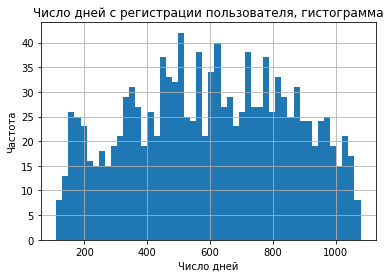

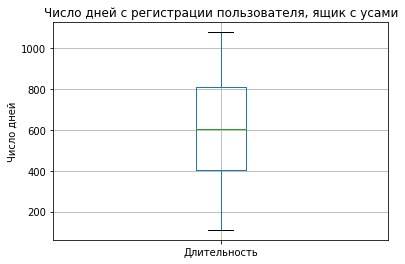

In [16]:
# 6 Маркет_актив_6_мес
hist_boxplot('Длительность','Число дней с регистрации пользователя','Число дней')

# Видим распределение, напоминающее нормальное, с центром в 600.

count    1252.000000
mean        0.313722
std         0.245076
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64


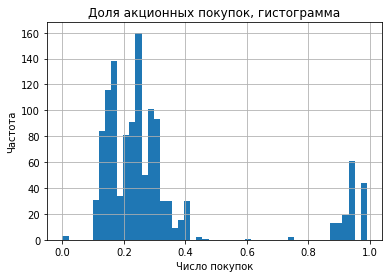

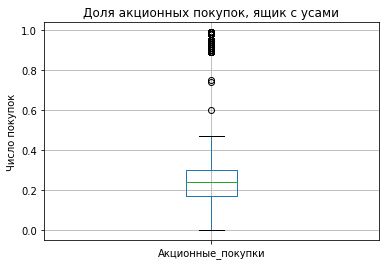

In [17]:
# 7 Акционные_покупки
hist_boxplot('Акционные_покупки','Доля акционных покупок','Число покупок')

# Видим бимодальное распределение : значения кластеризуются относительно значения 0.6 с центрами в 0,25 и 0,95.
ii=market_file[market_file['Акционные_покупки']>0.5].index
#print(len(ii))

Популярная_категория
Товары для детей                        318
Домашний текстиль                       240
Косметика и аксесуары                   213
Техника для красоты и здоровья          176
Мелкая бытовая техника и электроника    169
Кухонная посуда                         136
dtype: int64


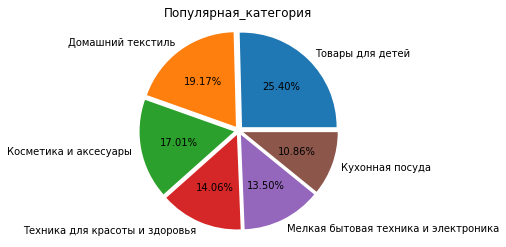

In [18]:
# 8 Популярная_категория
counts_pie('Популярная_категория')

Средний_просмотр_категорий_за_визит
3    342
2    296
4    260
5    170
1     99
6     85
dtype: int64


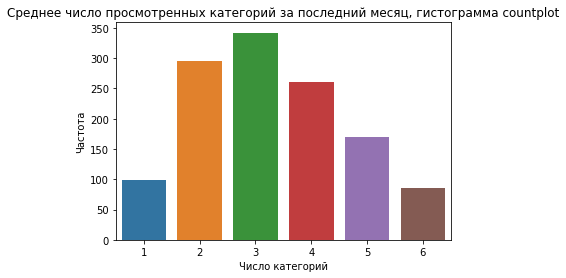

In [19]:
# 9 Средний_просмотр_категорий_за_визит - количественный дискретный.
counts_countplot(
    'Средний_просмотр_категорий_за_визит',
    'Среднее число просмотренных категорий за последний месяц',
    'Число категорий'
)

Неоплаченные_продукты_штук_квартал
1     258
2     258
3     201
4     189
5     131
0     109
6      40
7      34
8      19
9       9
10      4
dtype: int64


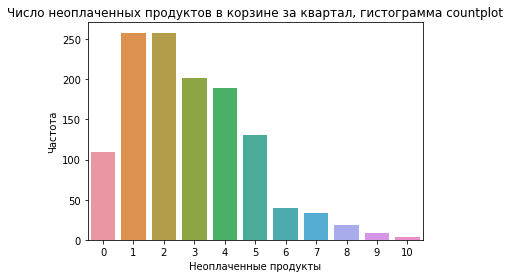

In [20]:
# 10 Неоплаченные_продукты_штук_квартал
counts_countplot(
    'Неоплаченные_продукты_штук_квартал',
    'Число неоплаченных продуктов в корзине за квартал',
    'Неоплаченные продукты'
)

Ошибка_сервиса
4    244
3    219
5    202
2    182
6    151
7     87
1     73
8     62
0     17
9     15
dtype: int64


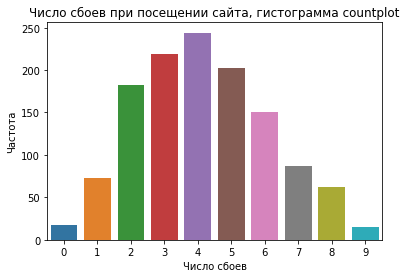

In [21]:
# 11 Ошибка_сервиса - количественный дискретный.
counts_countplot('Ошибка_сервиса','Число сбоев при посещении сайта','Число сбоев')

Страниц_за_визит
6     123
8     108
9     107
4     104
5     103
10    103
7     100
11     90
12     73
3      70
13     60
2      55
14     51
15     34
16     20
17     19
1      18
18      7
19      5
20      2
dtype: int64


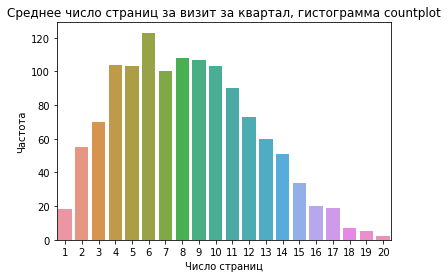

In [22]:
# 12 Страниц_за_визит - количественный дискретный
counts_countplot('Страниц_за_визит','Среднее число страниц за визит за квартал','Число страниц')

### Отбор клиентов с активностью не менее 3х месяцев
В п.задания 4.2 рекомендуется учитывать, что данные о выручке и времени на сайте в наборах <b>market_money</b>, <b>market_time</b> находятся в одном столбце для всех периодов. При объединении таблиц будет необходимо сделать отдельный столбец для каждого периода. Сделаем это сейчас - это, в том числе, облегчит задачу отбора клиентов с активностью не менее 3х месяцев.

In [23]:
# отбор id, актуальных после исследовательского анализа
market_money=market_money[market_money['id'].isin(market_file['id'])].reset_index(drop=True)
market_time=market_time[market_time['id'].isin(market_file['id'])].reset_index(drop=True)

# разнесение данных market_money по столбцам
ids=[]
prevprev_m=[]
prev_m=[]
cur_m=[]

market_money=market_money.sort_values(by=['id','Период']).reset_index(drop=True)

for ii in range(0,len(market_money.index),3):
    ids.append(market_money.loc[ii,'id'])
    prev_m.append(market_money.loc[ii,'Выручка'])
    prevprev_m.append(market_money.loc[ii+1,'Выручка'])
    cur_m.append(market_money.loc[ii+2,'Выручка'])
    
market_money=pd.DataFrame(data=ids,columns=['id'])
market_money['Выручка_препредыдущий']=prevprev_m
market_money['Выручка_предыдущий']=prev_m
market_money['Выручка_текущий']=cur_m    


# разнесение данных market_time по столбцам
ids=[]
prev_m=[]
cur_m=[]

market_time=market_time.sort_values(by=['id','Период']).reset_index(drop=True)

for ii in range(0,len(market_time.index),2):
    ids.append(market_time.loc[ii,'id'])
    prev_m.append(market_time.loc[ii,'минут'])
    cur_m.append(market_time.loc[ii+1,'минут'])
    
market_time=pd.DataFrame(data=ids,columns=['id'])
market_time['Минут_предыдущий']=prev_m
market_time['Минут_текущий']=cur_m    


# отбор клиентов с 3х-месячной активностью
ids=market_money[
    (market_money['Выручка_препредыдущий']!=0)&
    (market_money['Выручка_предыдущий']!=0)&
    (market_money['Выручка_текущий']!=0)
]['id']


# фильтрация            
market_file=market_file[market_file['id'].isin(ids)].reset_index(drop=True)
market_money=market_money[market_money['id'].isin(ids)].reset_index(drop=True)
market_time=market_time[market_time['id'].isin(ids)].reset_index(drop=True)
money=money[money['id'].isin(ids)].reset_index(drop=True)

### Вывод по п. 3 Исследовательский анализ данных

Проанализированы количественные и категориальные признаки, построены гистограммы, ящики с усами и круговые диаграммы.

Для количественных признаков устранены выбросы.

Размер итоговой выборки составляет 1252/1300 = <b><u>96%</u></b> от размера исходной, что явлется приемлемым результатом.

Отобраны клиенты, совершавшие покупки в каждом из последних 3х месяцев.

## Объединение таблиц

### Объединение таблиц market_file.csv, market_money.csv, market_time.csv

In [24]:
market_file=market_file.merge(market_money, on='id',how='left').merge(market_time, on='id',how='left')
display(market_file)

# изменение типов на более подходящие
market_file['Выручка_препредыдущий']=market_file['Выручка_препредыдущий'].astype('float32')
market_file['Выручка_предыдущий']=market_file['Выручка_предыдущий'].astype('float32')
market_file['Выручка_текущий']=market_file['Выручка_текущий'].astype('float32')
market_file['Минут_предыдущий']=market_file['Минут_предыдущий'].astype('int32')
market_file['Минут_текущий']=market_file['Минут_текущий'].astype('int32')

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_препредыдущий,Выручка_предыдущий,Выручка_текущий,Минут_предыдущий,Минут_текущий
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.600098,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.399902,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.399902,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.500000,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.500000,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,216642,Прежний уровень,премиум,да,4.2,3,991,0.40,Мелкая бытовая техника и электроника,4,3,5,12,5011.0,4589.5,4354.200195,19,19
1245,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5353.000000,12,11
1246,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5139.200195,12,18
1247,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4725.0,4923.0,5224.600098,18,7


### Исследовательский анализ добавленных признаков

count    1249.000000
mean     4840.655762
std       334.588196
min      4098.000000
25%      4587.000000
50%      4818.000000
75%      5072.000000
max      5663.000000
Name: Выручка_препредыдущий, dtype: float64


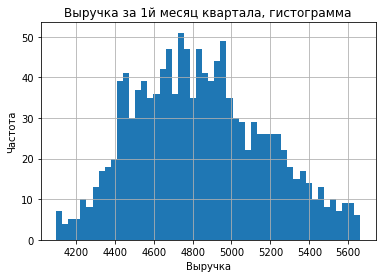

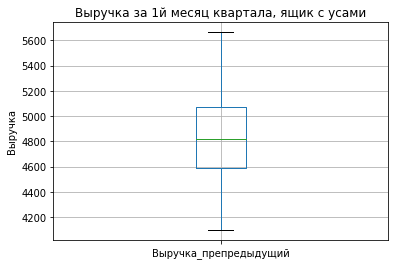

In [25]:
# 13 Выручка_препредыдущий
hist_boxplot('Выручка_препредыдущий','Выручка за 1й месяц квартала','Выручка')
# Видим нормальное распределение с центром в 4850.

count    1249.000000
mean     4949.315430
std       694.353149
min      2890.000000
25%      4502.000000
50%      5004.500000
75%      5398.000000
max      6869.500000
Name: Выручка_предыдущий, dtype: float64


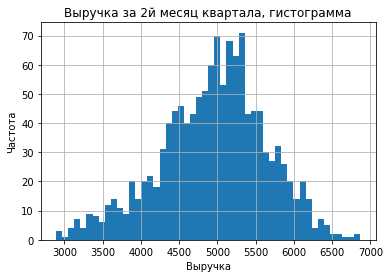

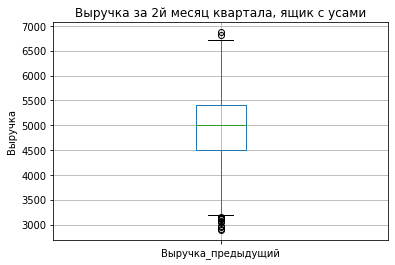

In [26]:
# 14 Выручка_предыдущий
hist_boxplot('Выручка_предыдущий','Выручка за 2й месяц квартала','Выручка')
# Видим нормальное распределение с центром в 4950. Выбросы оказались недалеко за усами - оставим.

count    1249.000000
mean     5229.854492
std       832.343933
min      2758.699951
25%      4704.399902
50%      5175.600098
75%      5745.600098
max      7799.399902
Name: Выручка_текущий, dtype: float64


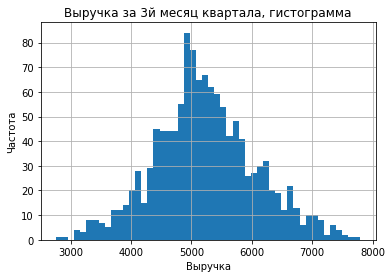

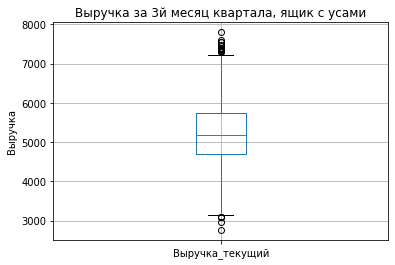

In [27]:
# 15 Выручка_текущий
hist_boxplot('Выручка_текущий','Выручка за 3й месяц квартала','Выручка')
# Видим нормальное распределение с центром в 5200. Выбросы оказались недалеко за усами - оставим.

Минут_предыдущий
14    110
12    110
11    109
13    108
15    106
10     95
17     91
16     81
18     81
9      70
8      66
19     60
20     50
7      41
21     26
6      20
5      10
22      9
23      6
dtype: int64


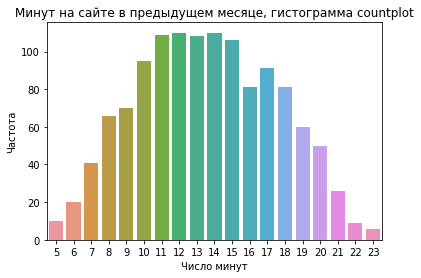

In [28]:
# 16 Минут_предыдущий - количественный дискретный
counts_countplot('Минут_предыдущий','Минут на сайте в предыдущем месяце','Число минут')

Минут_текущий
14    130
12    116
9     101
11    100
10     98
13     95
16     81
17     69
15     68
8      66
18     63
19     56
20     50
7      41
6      32
22     30
21     27
5      11
23      8
4       7
dtype: int64


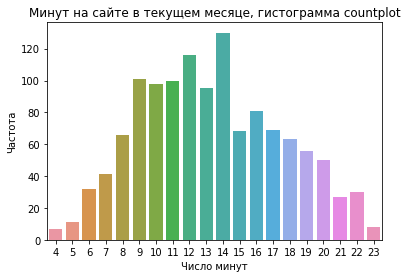

In [29]:
# 17 Минут_текущий - количественный дискретный
counts_countplot('Минут_текущий','Минут на сайте в текущем месяце','Число минут')

### Вывод по п. 4 Объединение таблиц
Таблицы <b>market_file.csv</b>, <b>market_money.csv</b>, <b>market_time.csv</b> объединены.

В итоговой таблице каждому периоду выручки и проведенного времени соответствует отдельный столбец.

Выполнен исследовательский анализ добавленных признаков.

## Корреляционный анализ
Расчет коэффициентов корреляции между количественными признаками посредством тепловой карты.

In [30]:
# создаём список с наименованиями количественных признаков
interval_cols = [
    'Маркет_актив_6_мес',
    #'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    #'Средний_просмотр_категорий_за_визит',
    #'Неоплаченные_продукты_штук_квартал',
    #'Ошибка_сервиса',
    #'Страниц_за_визит',
    'Выручка_препредыдущий',
    'Выручка_предыдущий',
    'Выручка_текущий',
    #'Минут_предыдущий',
    #'Минут_текущий'
]

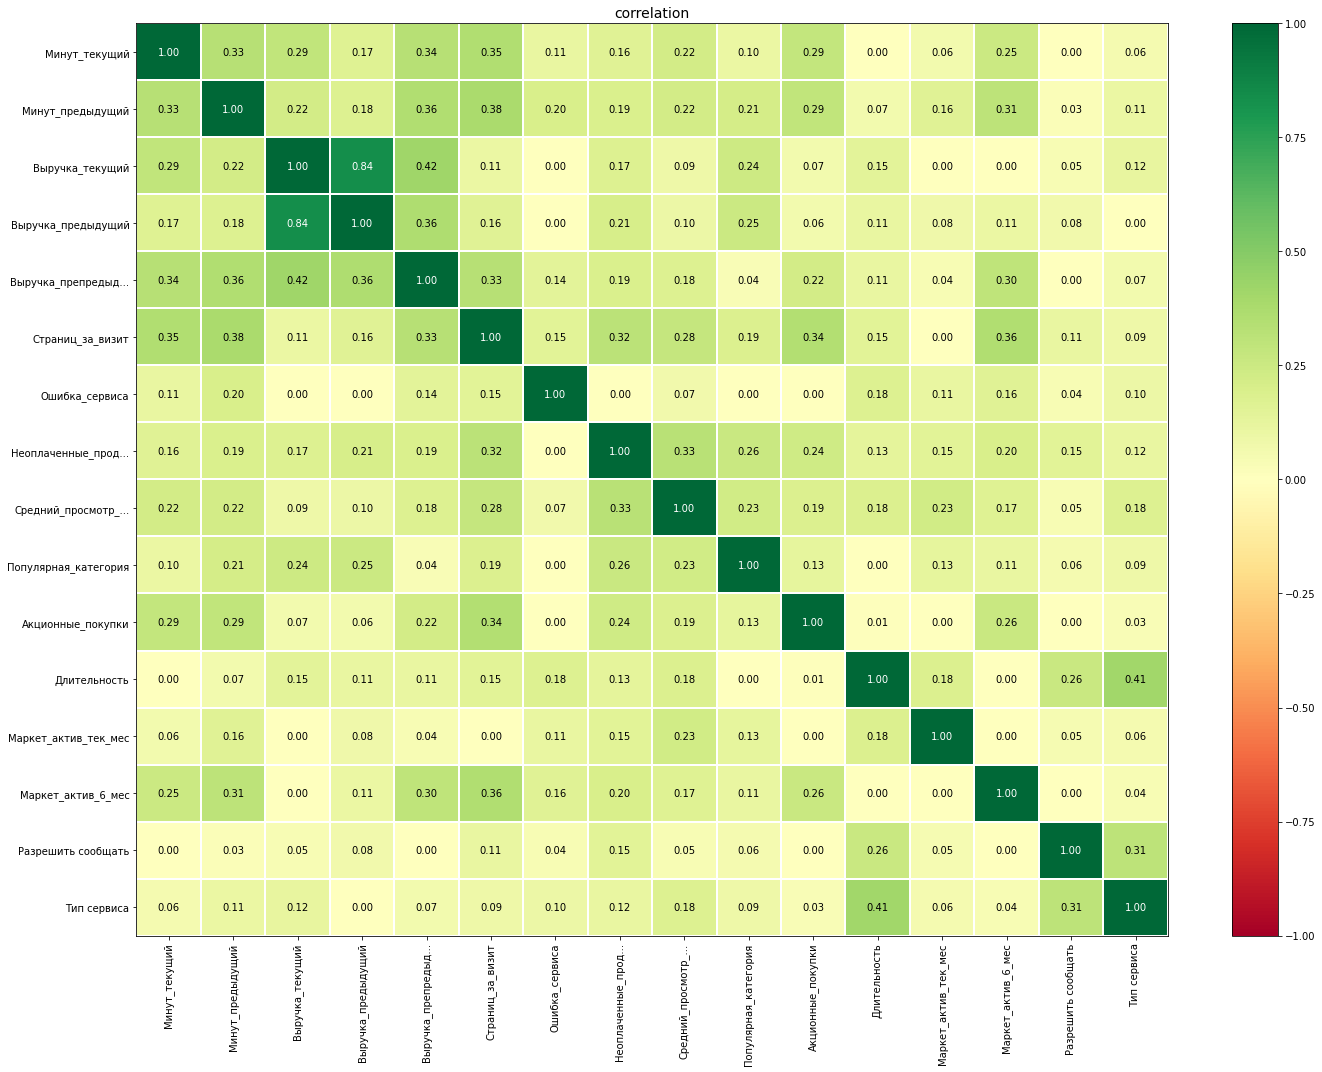

In [31]:
# Корреляция Пирсона не подходит в виду того, что некоторые признаки распределены ненормально.
# Используем корреляцию Спирмана.
#sns.heatmap(
#    market_file[interval_cols].corr(method='spearman'), 
#    annot=True, fmt='.2f'
#)

# либо инструментарий phik для большей наглядности (удается настраивать размер рисунка):
phik_overview = phik_matrix(market_file.drop(['id','Покупательская активность'],axis=1), interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(20, 15)
) 

На тепловой карте видим сильную корреляцию признаков <b>'Выручка_предыдущий'</b> и <b>'Выручка_текущий'</b> с коэффициентом близким к 1. Один из этих признаков следует удалить.

Также следует выделить заметную корреляцию (коэффициент ~0.48) признаков <b>'Минут_предыдущий'</b> и <b>'Страниц_за_визит'</b>, вытекающую из их логической связи - на просмотр большего числа страниц уходит больше времени. Однако считаю возможным оставить оба этих признака в наборе данных. 

In [32]:
# Удаление признака 'Выручка_предыдущий'
market_file=market_file.drop('Выручка_предыдущий',axis=1)

### Вывод по п. 5 Корреляционный анализ
Выполнен корреляционный анализ посредством инструментария <i>phik</i>. Выявлена сильная связь признаков <b>'Выручка_предыдущий'</b> и <b>'Выручка_текущий'</b> (коэффициент==0.84). Первый признак удален из набора данных.

## Использование пайплайнов
### Пайплайн подготовки данных
Следуем алгоритму:
<ul>
<li> создаём списки с названиями признаков;
<li> кодируем целевой признак вручную;
<li> формируем тренировочную и тестовую выборки;
<li> создаем пайплайн кодирования бинарных признаков посредством <b>OneHotEncoder</b>;
<li> создаем пайплайн кодирования номинального небинарного признака посредством <b>OrdinalEncoder</b>;
<li> создаем общий пайплайн подготовки данных (кодирование и масштабирование).  
</ul>

In [33]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# создаём списки с названиями признаков
#ohe_columns = ['Тип сервиса', 'Разрешить сообщать']
#ord_columns = ['Популярная_категория']

In [34]:
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса', 'Разрешить сообщать']

In [35]:
num_columns = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'Выручка_препредыдущий',
    'Выручка_текущий',
    'Минут_предыдущий',
    'Минут_текущий'
]

In [36]:
# формируем выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_file.drop(
        [
            'id',
            'Покупательская активность'
        ], 
        axis=1
    ),
    market_file['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_file['Покупательская активность']
)


In [37]:
# кодирование целевого признака
label_encoder = LabelEncoder()
# тренировочная выборка
y_train = label_encoder.fit_transform(y_train)
# тестовая выборка
y_test = label_encoder.transform(y_test)

In [38]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        (
            'ohe', 
            #OneHotEncoder(drop='first', handle_unknown='ignore')#, sparse=False)
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )                                                                      
    ]
)

In [39]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns
# OE
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        (
            'ord',
            OrdinalEncoder(             # признак номинальный - можно обойтись без categories
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [40]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Итоговый пайплайн
Создаем итоговый пайплайн обработки данных и моделирования. 

В словаре гиперпараметров пайплайна задаем гиперпараметры 4х моделей <b>DecisionTreeClassifier</b>, <b>KNeighborsClassifier</b>, <b>LogisticRegression</b>, <b>SVC</b>. 

В качестве скейлеров указываем варианты <b>StandardScaler</b>, <b>MinMaxScaler</b>, <b>RobustScaler</b>, <b>'passthrough'</b>.

В качестве инструмента подбора гиперпараметров используем <b>GridSearchCV</b>.

В качестве метрики качества модели используем <b>ROC-AUC</b> как всеохватывающую метрику качества классификации, учитывающую работу модели при всех возможных значениях порогов.

Придерживаемся стратегии использования одного общего пайплайна для всех моделей и инструмента подбора гиперпараметров, который вернёт вам лучшую модель.

In [41]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final=Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

# задание "гиперпараметров" пайплайна:
# - 4 скейлера
# - 4 модели с гиперпараметрами
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(),'passthrough']  
    },  
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(),'passthrough']   
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(),'passthrough']  
    },
    # словарь для модели SVC()
    {                         # закомментировано - см. вывод к п. 6 ниже
        'models': [SVC(
            random_state=RANDOM_STATE, 
            kernel='poly',
            probability=True
        )],
        'models__degree': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(),'passthrough']  
    }    
] 

In [42]:
# используем GridSearchCV в качестве инструмента подбора гиперпараметров
grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',  
    n_jobs = -1
)
grid_search.fit(X_train, y_train) 

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [43]:
# рассчет прогноза на тестовых данных
y_test_pred = grid_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8995608256477822


In [44]:
# использование DummyClassifier

# подготовка данных средствами пайплайна для использования в DummyClassifier
ohe_columns_=grid_search.best_estimator_['preprocessor']['ohe']['ohe'].get_feature_names_out().tolist()
xx=grid_search.best_estimator_['preprocessor'].transform(X_train)
X_train_processed=pd.DataFrame(data=xx,columns=ohe_columns_+ord_columns+num_columns)

xx=grid_search.best_estimator_['preprocessor'].transform(X_test)
X_test_processed=pd.DataFrame(data=xx,columns=ohe_columns_+ord_columns+num_columns)

dm=DummyClassifier(random_state=RANDOM_STATE)
dm.fit(X_train_processed,y_train)

# рассчет прогноза на тестовых данных
y_test_pred = dm.predict_proba(X_test_processed)[:,1]
print(f'Метрика ROC-AUC для DummyClassifier на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC для DummyClassifier на тестовой выборке: 0.5


### Вывод по п. 6 Использование пайплайнов
Построен паплайн подготовки данных и обучения модели.

Для категориальных бинарных признаков использован кодировщик <b>OneHotEncoder</b>, для категориального номинального признака - <b>OrdinalEncoder</b>. 

Скейлеры (нормировщики) <b>StandardScaler</b>, <b>MinMaxScaler</b>, <b>RobustScaler</b>, а также вариант без нормировки <b>'passthrough'</b> заданы в качестве гиперпараметров пайплайна.

Обучены модели <b>DecisionTreeClassifier</b>, <b>KNeighborsClassifier</b>, <b>LogisticRegression</b>, <b>SVC</b> с заданным набором гиперпараметров.

В качестве метрики качества модели использована <b>ROC-AUC</b>.

<b><u>ЛУЧШАЯ МОДЕЛЬ</u></b>

Лучшей оказалась модель <b>SVC</b> с гиперпараметрами <i>degree=1</i>, <i>kernel='poly'</i>.

Значение метрики на тренировочной выборке == <b><i><u>0.8958</u></i></b>, на тестовой == <b><i><u>0.9</u></i></b>.
    
<b><u><i>ОДНАКО</i></u></b> в следующем п. 7 <b>Анализ важности признаков</b> необходимо оценить важность признаков для лучшей модели с помощью метода <b>SHAP</b>. В теории к спринту рассматривалось использование этого метода лишь с линейными моделями (shap.LinearExplainer). Я не знаю, как использовать SHAP с моделью SVC, а примеры в Интернет выглядят замысловато. Был бы признателен получить подсказку.
    
В силу невозможности в настоящее время использовать SHAP с SVC, модель SVC исключена из пайплайна, и на месте лучшей модели оказалась <b>LogisticRegression</b> с гиперпараметром <i>C=1</i>.

Значение метрики на тренировочной выборке == <b><i><u>0.8957</u></i></b>, на тестовой == <b><i><u>0.8951</u></i></b>.
    
Полученные высокие значения метрик как модели <b>SVC</b>, так и модели <b>LogisticRegression</b> говорят об их <b>высоком качестве</b>.

## Анализ важности признаков
Оценка важности признаков для лучшей модели, полученная с помощью средств метода SHAP.

Сначала оценим общую важность путем построения столбчатой диаграммы.

Затем оценим влияние признаков на каждое предсказание модели.

In [45]:
# подготовка данных средствами пайплайна для использования в SHAP
#xx=grid_search.best_estimator_['preprocessor'].transform(X_test)
#X_test_processed=pd.DataFrame(data=xx,columns=ohe_columns+ord_columns+num_columns)

# получение оценок методом SHAP, с передачей "лучшей" модели и подготовленных данных
#explainer = shap.LinearExplainer(grid_search.best_estimator_['models'], X_test_processed)
#shap_values = explainer(X_test_processed)
#shap.plots.bar(shap_values,max_display=15)

explainer = shap.KernelExplainer(grid_search.best_estimator_['models'].predict_proba, X_test_processed)
shap_values = explainer(X_test_processed.sample(20))

Using 313 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/20 [00:00<?, ?it/s]

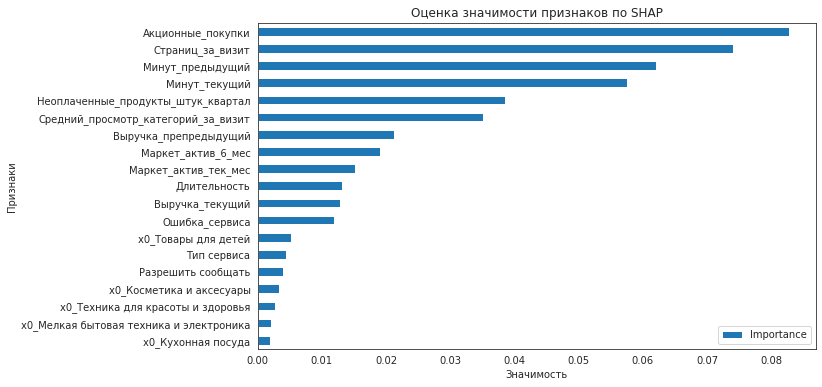

In [46]:
# получение общей оценки значимости признаков пуетм построения столбчатой диаграммы
    # при использовании shap.plots.bar(shap_values,max_display=15) интерпретатор выдает ошибку,
    # поэтому диаграмма построена своими руками:
# средние оценки каждого признака:
sh_v=[]
     
r_c=shap_values.values.shape[0]
c_c=shap_values.values.shape[1]
for cc in range(c_c):
    ss=0
    for rr in range(r_c):
        # for Logistic
        #ss=ss+np.abs(shap_values.values[rr,cc])
        # for SVC
        ss=ss+np.abs(shap_values.values[rr,cc,0])
    sh_v.append(ss/r_c)  
        
# строительство столбчатой диаграммы
feature_importance = pd.DataFrame({'Feature': X_test_processed.columns, 'Importance': sh_v})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

##
plt.title('Оценка значимости признаков по SHAP')
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.show()

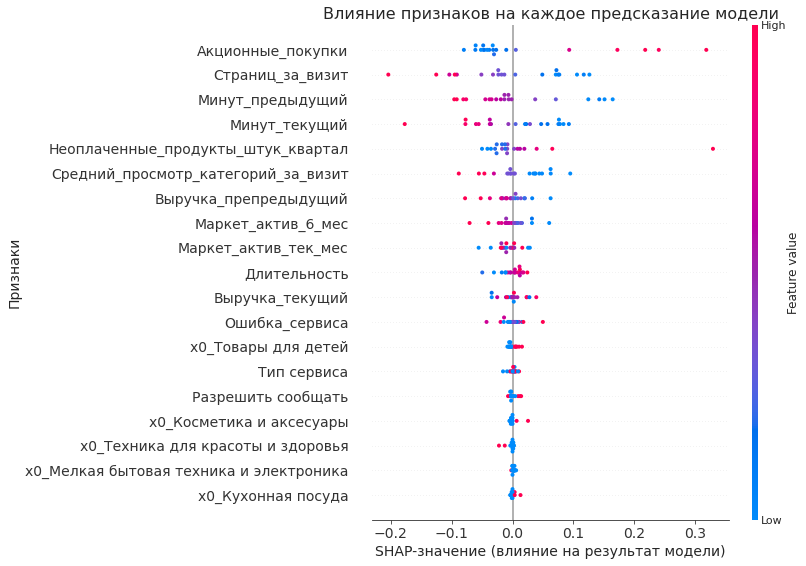

In [47]:
# оценим влияние признаков на каждое предсказание модели
sh_v=[]
for rr in range(r_c):
    ss=[]
    for cc in range(c_c):
        ss.append(shap_values.values[rr,cc,1])
    sh_v.append(ss)
shap_values.values=sh_v
    
shap.plots.beeswarm(shap_values, max_display=c_c,show=False)

##
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP-значение (влияние на результат модели)", fontsize=14)
ax.set_ylabel("Признаки", fontsize=14)
ax.set_title('Влияние признаков на каждое предсказание модели', fontsize=16)
plt.show()

### Вывод по п. 7 Анализ важности признаков

На основании столбчатой диаграммы общей важности признаков можно утверждать, что признаки (перечислены по убыванию значимости):
<ul>
<li>Выручка_препредыдущий
<li>Популярная_категория
<li>Длительность
<li>Разрешить сообщать
<li>Тип сервиса
<li>Выручка_текущий
<li>Ошибка_сервиса
<li>Маркет_актив_тек_мес    
</ul>
<b>малозначимы</b> для модели: имеют оценку важности меньше 0.2, а оценка трех последних и вовсе равна 0.

А <b>сильнее</b> всего влияют на целевой признак признаки:
<ul>
<li>Средний_просмотр_категорий_за_визит
<li>Страниц_за_визит    
<li>Акционные_покупки    
<li>Неоплаченные_продукты_штук_квартал
<li>Минут_предыдущий
<li>Минут_текущий
<li>Маркет_актив_6_мес    
</ul>

Полученные результаты можно <b>трактовать</b> следующим вполне очевидным образом: модель отмечает снижение активности покупателя (выставляет значение целевого признака "снизилась"), если фиксирует, что :
<ul>
<li>пользователь проводит меньше времени на сайте: просматривает меньше страниц и категорий товаров;
<li>среди его покупок преобладают акционные товары;
<li>в его корзине большое число неоплаченных товаров.     
</ul>
При этом показатели выручки оказываются далеко не самыми важными при классификации. Малозначимыми также оказываются такие признаки, как чило ошибок при работе с сайтом, тип сервиса или давность регистрации. 

Опираясь на результаты моделирования, можно сформулировать следующие общие <b>рекомендации</b>:
<ul>
<li>чаще информировать пользователя об акциях на товары в тех категориях, в которых он чаще совершает покупки;     
<li>предлагать пользователю больше товаров к просмотру в тех категориях, в которых он чаще совершает покупки;
<li>предлагать скидки при покупке одновременной нескольких товаров в категориях, в которых он чаще совершает покупки;
<li>предлагать персональные скидки на "избранные" товары, страницы которых пользователь часто просматривает в ожидании снижения цены;
<li>предлагать скидки на товары, долго находящиеся в корзине без оплаты. 
</ul>
  

## Сегментация покупателей

По заданию необходимо:
<ul>
<li>выделить сегмент покупателей, используя данные моделирования, данные о прибыли покупателей и исходные данные;
<li>проанализировать его и предложить, как увеличить его покупательскую активность.    
</ul>
 
Из приведенных в задании примеров сегментов остановимся на группе клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Посылка в задании верна : на диаграмме <b>SHAP-beeswarm</b> действительно наблюдаем, что высокие значения признака <b>'Акционные_покупки'</b> понуждают модель классифицировать активность покупателя, как снизившуюся.

Далее, такой сегмент может быть легко выделен, поскольку на гистограмме распределения значений признака <b>'Акционные_покупки'</b>, построенной на этапе исследовательского анализа, мы наблюдаем бимодальное распределение. На гистограмме отчетливо выделяется группа (сегмент) пользователей с высокой долей акционных покупок.

Выделим этот сегмент:

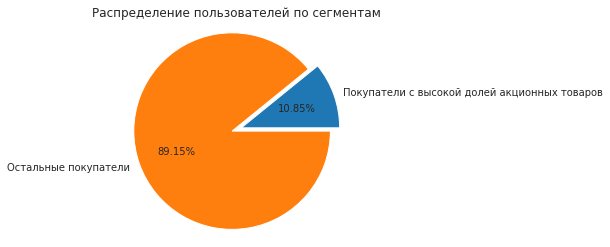

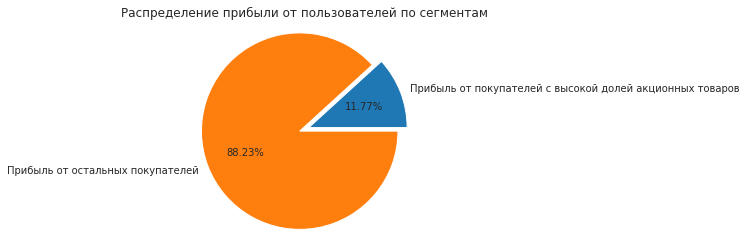

In [48]:
# отбор актуальных id
money=money[money['id'].isin(market_file['id'])]
# выделение сегмента
segm=market_file[market_file['Акционные_покупки']>0.6] # граница найдена на гистограмме распределения

# диаграмма распределения покупателей
plt.pie([len(segm),len(money)], explode=[0.05 for ee in range(2)], autopct='%4.2f%%',labels=[
    'Покупатели с высокой долей акционных товаров',
    'Остальные покупатели'
])
plt.axis("equal")
plt.title('Распределение пользователей по сегментам')
plt.show()

# прибыль по сегментам
revenue=[]
revenue.append(money[money['id'].isin(segm['id'])]['Прибыль'].sum())
revenue.append(money[~money['id'].isin(segm['id'])]['Прибыль'].sum())
# диаграмма распределения прибыли
plt.pie(revenue, explode=[0.05 for ee in range(len(revenue))], autopct='%4.2f%%',labels=[
    'Прибыль от покупателей с высокой долей акционных товаров',
    'Прибыль от остальных покупателей'
])
plt.axis("equal")
plt.title('Распределение прибыли от пользователей по сегментам')
plt.show()


### Вывод по п. 8 Сегментация покупателей
Выделен сегмент клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
Построены круговые диаграммы распределения покупателей по сегментам и прибыли по сегментам. Доля таких покупателей в общем числе - 10,85%, доля прибыли от таких покупателей при мерно та же - 11,77%. Т.е. такие покупатели не приносят ощутимо бОльшей прибыли, чем остальные. Тем не менее, это довольно заметная часть покупателей, прибыль от которых наверняка хотелось бы увеличить. 

Покупатели из этого сегмента предпочитают приобретать товары со скидками - они активны во время проведения акций, поэтому для повышения их активности следует:
<ul>
<li>либо чаще проводить общие акции-распродажи;
<li>либо устраивать частые <i>адресные</i> акции-распродажи избранных товаров или в избранных категориях.
</ul>    

## Общий вывод
<b><u>Описание задачи</u></b><br>
Отчёт интернет-магазина «В один клик» за прошлый период показал, что активность покупателей начала снижаться. Руководство магазина предпринимает попытки удерживать активность постоянных клиентов с помощью персонализированных предложений.

<b><u>Цель проекта</u></b> заключается в:
<ul>
<li>построении модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;
<li>выделении сегментов покупателей и разработке для них персонализированных предложений на основании данных модели и данных о прибыльности клиентов, дополнительно полученных от финансового департамента.
</ul>

<b><u>Исходными данными</u></b> служат датафреймы <i>market_file</i>, <i>market_money</i>, <i>market_time</i> и <i>money</i>, где соответственно представленны данные, описывающие активность клиентов, выручку, принесенную клиентами за последний квартал, время, проведенное клиентами на сайте магазина в последние два месяца и прибыль от каждого клиента.

В ходе <b><u>предобработки</u></b>:
<ul>
<li>типы данных столбцов были изменены на типы, характерные для данных в этих столбцах, что позволило уменьшить объем занимаемой памяти;
<li>пропусков в данных не обнаружено;
<li>дубликатов в данных не обнаружено;
<li>в некоторых категориальных признаках датафреймов market_file, market_time обнаружены опечатки. Опечатки устранены.
</ul>

В ходе <b><u>исследовательского анализа</u></b> были построены гистограммы распределения и ящики с усами для количественных признаков и круговые диаграммы для качественных.

На этапе <b><u>корреляционного анализа</u></b> посредством инструментария <i>phik</i> выявлена сильная связь признаков <b>'Выручка_предыдущий'</b> и <b>'Выручка_текущий'</b> (коэффициент==0.84). Первый признак удален из набора данных.

Для <b><u>поиска лучшей модели</u></b> был создан пайплайн, включающий этапы:
<ul>
<li>кодирования качественных признаков (номинальных бинарных и номинального небинарного); 
<li>масштабирования количественных;
<li>обучения прогнозной модели.
</ul>

В качестве <b><u>гиперпараметров пайплайна</u></b> были заданы:
<ul> 
<li>4 варианта масштабирования количественных признаков;
<li>4 модели : <i>DecisionTreeClassifier</i>, <i>KNeighborsClassifier</i>, <i>LogisticRegression</i>, <i>SVC</i>, которым, в свою очередь, были переданы их гиперпараметры.
</ul>

<b>Лучшей</b> оказалась модель <i>SVC</i> со значением метрики <i>accuracy</i> на тестовой выборке ==<b>0.9</b>.
Однако на этапе оценки важности параметров возникли сложности с использованием инструментария <i>SHAP</i> для модели <i>SVC</i>.
Поэтому в качесве лучшей модели была взята следующая по качеству <i>LogisticRegression</i> со значением метрики <i>roc-auc</i> на тестовой выборке ==<b>0.8915</b>. Высокие значения метрики говорят о высоком прогнозном качестве моделей.

На этапе <b><u>анализа важности</u></b> признаков посредством инструментария <i>SHAP</i> было установлено, что сильнее всего влияют на целевой признак признаки:
<ul>
<li>Средний_просмотр_категорий_за_визит
<li>Страниц_за_визит    
<li>Акционные_покупки    
<li>Неоплаченные_продукты_штук_квартал
<li>Минут_предыдущий
<li>Минут_текущий
<li>Маркет_актив_6_мес    
</ul>

Полученные результаты можно <b>трактовать</b> следующим вполне очевидным образом: модель отмечает снижение активности покупателя (выставляет значение целевого признака "снизилась"), если фиксирует, что :
<ul>
<li>пользователь проводит меньше времени на сайте: просматривает меньше страниц и категорий товаров;
<li>среди его покупок преобладают акционные товары;
<li>в его корзине большое число неоплаченных товаров.     
</ul>

Опираясь на результаты моделирования, были сформулированы следующие общие <b>рекомендации</b>:
<ul>
<li>чаще информировать пользователя об акциях на товары в тех категориях, в которых он чаще совершает покупки;     
<li>предлагать пользователю больше товаров к просмотру в тех категориях, в которых он чаще совершает покупки;
<li>предлагать скидки при покупке одновременной нескольких товаров в категориях, в которых он чаще совершает покупки;
<li>предлагать персональные скидки на "избранные" товары, страницы которых пользователь часто просматривает в ожидании снижения цены;
<li>предлагать скидки на товары, долго находящиеся в корзине без оплаты. 
</ul>

На этапе <b><u>сегментации покупателей</u></b> был исследован сегмент клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
Построены круговые диаграммы распределения покупателей по сегментам и прибыли по сегментам. Доля таких покупателей в общем числе - 10,85%, доля прибыли от таких покупателей при мерно та же - 11,77%. Т.е. такие покупатели не приносят ощутимо бОльшей прибыли, чем остальные. Тем не менее, это довольно заметная часть покупателей, прибыль от которых наверняка хотелось бы увеличить. 

Покупатели из этого сегмента предпочитают приобретать товары со скидками - они активны во время проведения акций, поэтому для повышения их активности следует:
<ul>
<li>либо чаще проводить общие акции-распродажи;
<li>либо устраивать частые <i>адресные</i> акции-распродажи избранных товаров или в избранных категориях.
</ul> 